In [96]:
PROJECT_DIR = '/home/thanuja/Dropbox/capstone/'
APP_SYS_NAME = 'BGL'
#APP_SYS_NAME = 'Thunderbird'

In [97]:
BASE_DIR = PROJECT_DIR + 'output/'
RAW_DIR = PROJECT_DIR + 'raw_files/'

# Imports

In [98]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix , precision_score, recall_score
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from scipy.spatial.distance import cosine
import warnings
import matplotlib.pyplot as plt
import sys
import subprocess
import random

random.seed(2)
sys.path.append(PROJECT_DIR) # this is done to make the import of ad_feature_extraction work
from ad_feature_extraction import parsers

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

# Preprocessing

Input_data Shape: (94000, 66)
label
False    86698
True      7302
Name: count, dtype: int64


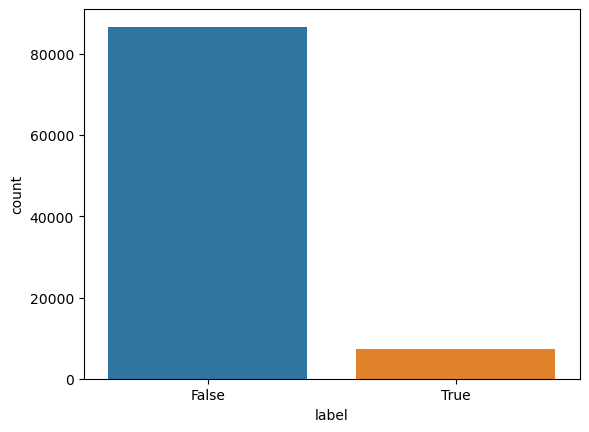

In [99]:
input_data = pd.read_csv(BASE_DIR + APP_SYS_NAME + '_clusters2.csv')

print("Input_data Shape:",input_data.shape)
print(input_data['label'].value_counts())

sns.countplot(x=input_data['label'])
plt.show()

In [100]:
le = LabelEncoder()
input_data['label'] = le.fit_transform(input_data['label']) # false:0 and true:1

X = input_data[['tfidf_text']].dropna()
y = input_data.loc[X.index,'label'].values

print("columns for the X file"+ str(X.columns))
print(X.shape,y.shape)

columns for the X fileIndex(['tfidf_text'], dtype='object')
(94000, 1) (94000,)


In [101]:
# do tfidf and kmeans on input_data and get homegeneity and completeness scores.
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X['tfidf_text'])
print('tfidf shape', X_tfidf.shape)

k = input_data['cluster2'].max() + 1
print('Using k = ', k)
kmeans = KMeans(k, random_state=0)
kmeans.fit(X_tfidf)

pred = kmeans.predict(X_tfidf)
labels = y

print("_______________________________________________")
print(f"Completeness Score: \n {completeness_score(labels, pred)}\n")
print(f"Homogeneity Score: \n {homogeneity_score(labels, pred)}\n") 

tfidf shape (94000, 1340)
Using k =  36
_______________________________________________
Completeness Score: 
 0.10329776759892763

Homogeneity Score: 
 0.9895714207657771



In [102]:
# count log lines within each cluster
output = X.copy()
output['cluster2'] = pred
output['label'] = input_data.loc[X.index, 'label']
print(output.groupby(['cluster2', 'label']).count())

                tfidf_text
cluster2 label            
0        0            3357
1        0           36066
2        0            1397
3        0              10
         1            5004
4        0            7795
5        0            4729
6        0             908
7        0            2454
         1               5
8        0            1987
9        0            2010
10       0             288
11       0            3254
12       0            1985
13       0            1308
14       1             876
15       0            5169
16       0             939
17       0             960
18       0            1228
19       0             843
20       0             754
21       0             523
22       1             477
23       0             505
24       1             905
25       0             240
26       0             500
27       0             638
28       0            1169
29       0            1475
30       0             564
31       0             670
32       0            1211
 

# Use label to determine which clusters are anomalies

In [103]:
print(output.groupby(['cluster2', 'label']).count())
counts_by_label_df = output.groupby(['cluster2', 'label']).count().reset_index()
pos_df = counts_by_label_df[counts_by_label_df['label'] == 1]
neg_df = counts_by_label_df[counts_by_label_df['label'] == 0]
anomaly_clusters = []
normal_clusters = []
for _, row in pos_df.iterrows():
    cluster = row['cluster2']
    pos = row['tfidf_text']
    neg = neg_df[neg_df["cluster2"] == cluster]['tfidf_text'].sum()
    print(cluster, 'pos neg', pos, neg)
    if pos > neg:
        anomaly_clusters.append(cluster)

for _, row in neg_df.iterrows():
    cluster = row['cluster2']
    neg = row['tfidf_text']
    pos = pos_df[pos_df["cluster2"] == cluster]['tfidf_text'].sum()
    if neg >= pos:
        normal_clusters.append(cluster)

print('anomaly clusters', anomaly_clusters)
print('normal clusters', normal_clusters)

                tfidf_text
cluster2 label            
0        0            3357
1        0           36066
2        0            1397
3        0              10
         1            5004
4        0            7795
5        0            4729
6        0             908
7        0            2454
         1               5
8        0            1987
9        0            2010
10       0             288
11       0            3254
12       0            1985
13       0            1308
14       1             876
15       0            5169
16       0             939
17       0             960
18       0            1228
19       0             843
20       0             754
21       0             523
22       1             477
23       0             505
24       1             905
25       0             240
26       0             500
27       0             638
28       0            1169
29       0            1475
30       0             564
31       0             670
32       0            1211
 

# Create summary report for clusters. Give example log line for each cluster.

In [104]:
summary_file_name = BASE_DIR + APP_SYS_NAME + '_cluster_summary.csv'
output_file = open(summary_file_name, 'w')
with output_file:
    writer = csv.writer(output_file)
    writer.writerow(['is_anomaly', 'anomaly_count', 'normal_count',
                     'cluster', 'pct_of_total',
                     'most_similar_sample', 'most_similar_distance',
                     'least_similar_sample', 'least_similar_distance'])
    
    def print_clusters(clusters, label):
        num_rows = X.shape[0]
        for ac in clusters:
            indices = X.index[pred == ac]
            rows_for_cluster = X_tfidf[pred == ac]
            centroid = kmeans.cluster_centers_[ac]
            least_distance = 0
            most_similar = None
            greatest_distance = 1
            least_similar = None
            for i in range(rows_for_cluster.shape[0]):
                row = np.asarray(rows_for_cluster[i].todense()).reshape(-1)
                distance = cosine(centroid, row)
                if most_similar is None or least_distance > distance:
                    least_distance = distance
                    most_similar = i
        
                if least_similar is None or greatest_distance < distance:
                    greatest_distance = distance
                    least_similar = i
                
            pct = round(np.count_nonzero(pred == ac) / num_rows, 2)
            writer.writerow([1 if label == 'anomaly' else 0,
                             pos_df[pos_df["cluster2"] == ac]['tfidf_text'].sum(),
                             neg_df[neg_df["cluster2"] == ac]['tfidf_text'].sum(),
                             ac, pct,
                             input_data.loc[indices[most_similar], 'text'], round(least_distance, 3),                  
                             input_data.loc[indices[least_similar], 'text'], round(greatest_distance, 3)])
    print_clusters(anomaly_clusters, 'anomaly')
    print_clusters(normal_clusters,  ' normal')
    
summary_df = pd.read_csv(summary_file_name)
summary_df

,is_anomaly,anomaly_count,normal_count,cluster,pct_of_total,most_similar_sample,most_similar_distance,least_similar_sample,least_similar_distance
0,1,5004,10,3,0.05,RAS KERNEL FATAL data TLB error interrupt,0.000,RAS KERNEL FATAL debug interrupt enable..........,0.419
1,1,876,0,14,0.01,RAS KERNEL FATAL Lustre mount FAILED : bglio88...,0.000,RAS KERNEL FATAL Lustre mount FAILED : bglio88...,0.000
2,1,477,0,22,0.01,RAS KERNEL FATAL rts: kernel terminated for re...,0.021,RAS KERNEL FATAL rts: kernel terminated for re...,0.498
3,1,905,0,24,0.01,RAS KERNEL FATAL data storage interrupt,0.000,RAS KERNEL FATAL data storage interrupt,0.000
4,0,0,3357,0,0.04,RAS KERNEL INFO 4326408 double-hummer alignmen...,0.000,RAS KERNEL INFO 4326408 double-hummer alignmen...,0.000
5,0,0,36066,1,0.38,RAS KERNEL INFO generating core.51,0.000,RAS KERNEL INFO generating core.7,0.285
6,0,0,1397,2,0.01,RAS KERNEL INFO iar 00106210 dear 0244c20c,0.155,RAS KERNEL INFO iar 00106210 dear 0244c26c,0.175
7,0,0,7795,4,0.08,RAS KERNEL INFO iar 003a929c dear 012987f8,0.001,RAS KERNEL INFO iar 00106580 dear 045e142c,0.499
8,0,0,4729,5,0.05,RAS MMCS ERROR idoproxydb hit ASSERT condition...,0.000,RAS MMCS ERROR idoproxydb hit ASSERT condition...,0.000
9,0,0,908,6,0.01,RAS KERNEL INFO 2354412 floating point alignme...,0.000,RAS KERNEL INFO 2354412 floating point alignme...,0.000


# Use TFIDF and KMeans from above to predict anomalies in original raw file

In [105]:
cluster_to_label_map = np.zeros(k)
for c in anomaly_clusters:
    cluster_to_label_map[c] = 1
    
for c in normal_clusters:
    cluster_to_label_map[c] = 0

def process_raw_file(raw_filename, parser):
    block_size = 100000 # entire dataset will not fit in memory, so do a block at a time
    file_path = raw_filename.split('/')
    with open(raw_filename, "r", encoding="utf8", errors='ignore') as raw_file:
        count = 0
        fp_total = tp_total = fn_total = 0
        row_block = []
        y_block = np.zeros(block_size)
        for line in raw_file:
            line = line.rstrip('\n')
            epochts,text,is_anomaly,filename = parser(file_path, line)
            y_block[count % block_size] = 1 if is_anomaly else 0
            count += 1
            row_block.append(text)
            
            if count % block_size == 0:
                X_block = tfidf.transform(row_block)
                block_clusters = kmeans.predict(X_block)
                block_pred = np.zeros(block_size)
                for i in range(block_clusters.shape[0]):
                    block_pred[i] = cluster_to_label_map[block_clusters[i]]
                fp = (block_pred == 1) & (y_block == 0)
                tp = (block_pred == 1) & (y_block == 1)
                fn = (block_pred == 0) & (y_block == 1)
                fp_total += np.count_nonzero(fp)
                tp_total += np.count_nonzero(tp)
                fn_total += np.count_nonzero(fn)
                print(count, fp_total, tp_total, fn_total)
                row_block = []

            # Remove this condition to process full file.
            if count > 3000000: break
        print(raw_filename, 'precision', tp_total / (fp_total + tp_total))
        print(raw_filename, 'recall', tp_total / (fn_total + tp_total))

process_raw_file(RAW_DIR + APP_SYS_NAME + '/' + APP_SYS_NAME + '.log', parsers[APP_SYS_NAME])

100000 1 477 2132
200000 1938 478 2291
300000 1941 77343 2298
400000 2409 169044 3323
500000 2409 203524 3323
600000 2409 216148 3323
700000 2409 216148 3323
800000 2410 216148 5373
900000 2429 216149 8754
1000000 2430 216149 8772
1100000 2431 216149 8779
1200000 2432 216149 8828
1300000 2433 216149 9024
1400000 2437 216661 9033
1500000 2437 216661 9033
1600000 2443 217311 10631
1700000 2443 217311 10631
1800000 2443 217311 10631
1900000 2443 217311 10632
2000000 2445 217917 10816
2100000 2448 217917 10827
2200000 2448 217917 10827
2300000 2448 219021 10827
2400000 2450 219022 10830
2500000 2458 220760 10930
2600000 2458 220760 10930
2700000 2460 220760 10934
2800000 2464 220935 10944
2900000 2464 220935 10944
3000000 2523 221583 12327
/home/thanuja/Dropbox/capstone/raw_files/BGL/BGL.log precision 0.9887419346202243
/home/thanuja/Dropbox/capstone/raw_files/BGL/BGL.log recall 0.947300243683468


# Compute precision, recall, homogeneity, confusion matrix

BGL Result:
Accuracy Score: 99.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999539     0.998625  0.999468      0.999082      0.999468
recall         0.999885     0.994522  0.999468      0.997203      0.999468
f1-score       0.999712     0.996569  0.999468      0.998140      0.999468
support    86698.000000  7302.000000  0.999468  94000.000000  94000.000000
_______________________________________________
Confusion Matrix: 
 [[86688    10]
 [   40  7262]]

_______________________________________________
Completeness Score: 
 0.10329776759892763

_______________________________________________
Homogeneity Score: 
 0.9895714207657771

_______________________________________________
Precision Score: 
 0.9986248624862486
_______________________________________________
Recall Score: 
 0.994522048753766
_______________________________________________
Roc AUC Score: 
 0.9972

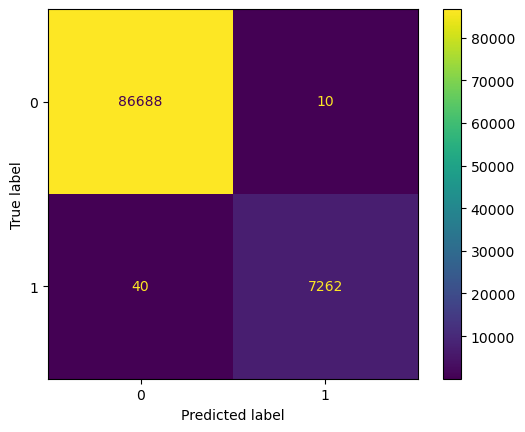

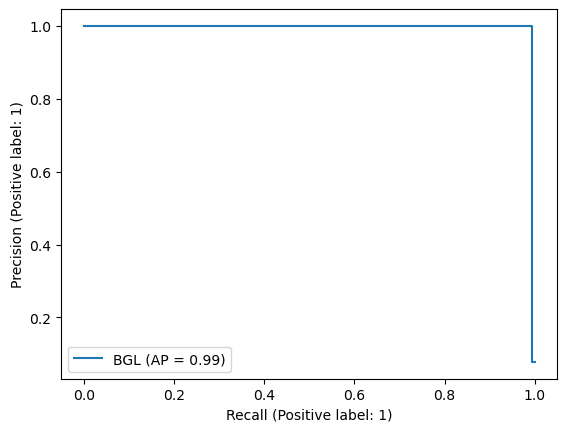

In [106]:
def report(report_name, pred, labels):
    label_pred = np.zeros(pred.size)
    for i in range(pred.size):
        label_pred[i] = cluster_to_label_map[pred[i]]
    kmeans_report = pd.DataFrame(classification_report(labels, label_pred, output_dict=True))
    print(f"{report_name} Result:\n================================================")        
    print(f"Accuracy Score: {accuracy_score(labels, label_pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{kmeans_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(labels, label_pred)}\n")
    
    print("_______________________________________________")
    print(f"Completeness Score: \n {completeness_score(labels, pred)}\n")
    print("_______________________________________________")
    print(f"Homogeneity Score: \n {homogeneity_score(labels, pred)}\n")
    
    print("_______________________________________________")
    print(f'Precision Score: \n {precision_score(labels, label_pred)}')
    print("_______________________________________________")
    print(f'Recall Score: \n {recall_score(labels, label_pred)}')
    print("_______________________________________________")
    print(f'Roc AUC Score: \n {roc_auc_score(labels, label_pred)}')
   
    ConfusionMatrixDisplay.from_predictions(labels, label_pred)
    plt.show()
    
    PrecisionRecallDisplay.from_predictions(labels, label_pred, name=report_name)
    plt.show()

report(APP_SYS_NAME, pred, output.label.values)

# TSNE Scatterplot

94000


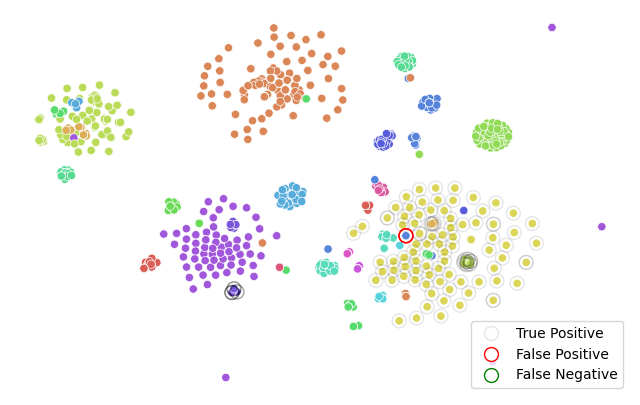

In [107]:
from sklearn.manifold import TSNE
import seaborn as sns

tfidf_tsne = TfidfVectorizer()
X_tfidf_tsne = tfidf_tsne.fit_transform(input_data.loc[X.index, 'text'])

print(output.shape[0])
output_sample = output.sample(1500, random_state=0)
X_tfidf_sample = X_tfidf_tsne[output_sample.index]
#print(np.bincount(output_sample['cluster2']))

for perplexity in range(35, 36, 5):
    tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=1000, learning_rate='auto', random_state=1, init="random")
    tsne_result = tsne.fit_transform(np.asarray(X_tfidf_sample.todense()))
    #tsne_result = tsne.fit_transform(X_tfidf_sample)

    #print(tsne_result)
    plt.figure(figsize=(8,5))


    tsne_df = output_sample.copy()
    tsne_df['tsne_one'] = tsne_result[:,0]
    tsne_df['tsne_two'] = tsne_result[:,1]

    ax= sns.scatterplot(
        x='tsne_one', y='tsne_two',
        hue="cluster2",
        #edgecolor=sns.color_palette("hls", 20),
        palette=sns.color_palette("hls", 20),
        #palette=sns.color_palette("blend:white,white"),
        data=tsne_df,
        legend=None,
        alpha=1,
        #s=70, facecolor='none', linewidth=1.5
    )
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax.set_frame_on(False)

    #sns.move_legend(ax, "center right")
    label_df = tsne_df[tsne_df['label'] == 1]
    
    legend_elements = [Line2D([0], [0], marker='o', color='white', markeredgecolor='black', label='True Positive', markerfacecolor='white', markersize=10, alpha=0.1),
                       Line2D([0], [0], marker='o', color='white', markeredgecolor='red', label='False Positive', markerfacecolor='white', markersize=10),
                       Line2D([0], [0], marker='o', color='white', markeredgecolor='green', label='False Negative', markerfacecolor='white', markersize=10)]
    ax.legend(handles=legend_elements, loc='lower right')

    '''
    tsne_centers = np.zeros((kmeans.cluster_centers_.shape[0], 2))
    tsne_radius = np.zeros(kmeans.cluster_centers_.shape[0])
    for i in range(kmeans.cluster_centers_.shape[0]):
        tsne_cluster = tsne_result[output_sample.cluster2 == i]
        tsne_centers[i] = np.mean(tsne_cluster, axis=0)
        tsne_radius[i] = np.max(np.max(tsne_cluster, axis=1) - np.min(tsne_cluster, axis=1))
    anomaly_tsne_centers = tsne_centers[anomaly_clusters]
    anomaly_tsne_radius = tsne_radius[anomaly_clusters]
    print(anomaly_tsne_radius)
    #anomaly_tsne_centers = anomaly_tsne_centers[anomaly_tsne_radius < 75]
    #anomaly_tsne_radius = anomaly_tsne_radius[anomaly_tsne_radius < 75]
    plt.scatter(anomaly_tsne_centers[:, 0], anomaly_tsne_centers[:, 1], s=anomaly_tsne_radius*10,
                facecolors='none', edgecolors='black')
    '''
    
    true_positives = tsne_result[output_sample.cluster2.isin(anomaly_clusters) & (output_sample.label == 1)]
    plt.scatter(true_positives[:, 0], true_positives[:, 1], s=100, facecolors='none', edgecolors='black', alpha=0.1)
    
    false_positives = tsne_result[output_sample.cluster2.isin(normal_clusters) & (output_sample.label == 1)]
    #print(false_positives)
    plt.scatter(false_positives[:, 0], false_positives[:, 1], s=100, facecolors='none', edgecolors='red')
    
    false_negatives = tsne_result[output_sample.cluster2.isin(anomaly_clusters) & (output_sample.label == 0)]
    #print(false_negatives)
    plt.scatter(false_negatives[:, 0], false_negatives[:, 1], s=100, facecolors='none', edgecolors='green')
    
    
    plt.show()
